In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import norm as normal

float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
sns.set_style('whitegrid')

In [58]:
path = r'C:\Users\antoi\desktop\PhD\PhD_year1\Macro2\pset3'

In [59]:
def tauchen(ρ, σ, N, μ, m):
    #This function discretizes an AR(1) process following the Tauchen method
    #y_t = μ(1 - ρ) + ρy_t + σϵ
    #ϵ ~ N(0, 1)
    #N is the number of states
    
    yN = μ + m*((σ**2)/(1 - ρ**2))**(1/2)
    y1 = μ - m*((σ**2)/(1 - ρ**2))**(1/2)
    Δ = (yN - y1)/(N-1)
    y = np.linspace(y1, yN, N) #discretization

    #Compute the transition matrix
    M = np.ones((N, N))
    for i in range(N):
        M[i, 0] = normal.cdf((y[0] + Δ/2 - ρ*y[i] - μ*(1 - ρ))/σ)
        M[i, N-1] = 1 - normal.cdf((y[-2] + Δ/2 - ρ*y[i] - μ*(1 - ρ))/σ)
        for j in range(1, N-1):
            M[i, j] = normal.cdf((y[j] + Δ/2 - ρ*y[i] - μ*(1 - ρ))/σ) - normal.cdf((y[j] - Δ/2 - ρ*y[i] - μ*(1 - ρ))/σ)
            
    return M, y

In [60]:
M, ygrid = tauchen(ρ=0.4, σ=0.05, N=2, μ=1, m=1)

In [61]:
ygrid

array([0.945, 1.055])

In [62]:
M

array([[0.669, 0.331],
       [0.331, 0.669]])

In [64]:
g = (0.05**2/(1-0.4**2))**(1/2)
M = np.array([[0.7, 0.3],
              [0.3, 0.7]])
ygrid = np.array([1-g, 1+g])

In [65]:
class dynamic_problem:
    def __init__(self, ρ, σ, N, s, r, β, g, prec, dmin, dmax):
        self.ρ = ρ
        self.σ = σ
        self.N = N
        self.s = s #utility σ parameter
        self.r = r
        self.β = β
        self.g = g
        self.prec = prec
        self.dmin = dmin
        self.dmax = dmax
    def vfi(self, maxiter=1000, tol=1e-8, norm=1e6):  
        dgrid = np.linspace(self.dmin, self.dmax, self.prec)
        
        Cmat = np.empty((self.N, self.prec, self.prec)) #Q[i, j, k] = value of being in y[i], d[j] and choosing d[k]
        for i in range(self.N):
            for j in range(self.prec):
                for k in range(self.prec):
                    Cmat[i, j, k] = ygrid[i] + dgrid[k] - self.g - (1+self.r)*dgrid[j]
                    
        UCmat = np.where(Cmat > 0, (Cmat**(1-self.s) - 1)/(1-self.s), -10000)
        
        Vk = np.ones((self.N, self.prec, 1))
        n_iter = 0
        while (n_iter < maxiter and norm > tol):
            EVk = np.expand_dims(M@Vk.reshape(self.N, self.prec), 0).reshape(self.N, 1, self.prec)
            Q = UCmat + self.β*EVk
            Vkprim = np.max(Q, axis=2).reshape(self.N, self.prec, 1)
            norm = np.max(np.abs(Vkprim - Vk))
            Vk = Vkprim.copy()
            n_iter += 1
        print(f"VFI converged in {n_iter} iterations.")
        d_policy = dgrid[np.argmax(Q, axis=2)].reshape(self.N, -1)

        self.dgrid = dgrid
        self.Vk = Vk
        self.d_policy = d_policy
        
        return dgrid, Vk, d_policy

    def plot_vf(self):
        #Value function
        plt.plot(self.dgrid, self.Vk[0, :], label="$y^{low}$")
        plt.plot(self.dgrid, self.Vk[1, :], label="$y^{high}$")
        
        plt.title("Value function")
        plt.legend()
        plt.savefig(path+"/valuefunction.png")
        plt.show()

    def plot_pf(self):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes = axes.flatten()

        #d' pf
        sns.lineplot(x=self.dgrid, y=self.d_policy[0, :], ax=axes[0], label='$y^{low}$')
        sns.lineplot(x=self.dgrid, y=self.d_policy[1, :], ax=axes[0], label='$y^{high}$')
        sns.lineplot(x=self.dgrid, y=self.dgrid, ax=axes[0], label='45° line')
        axes[0].set_title("$d'$ policy function")

        #c pf
        self.c_policy_l = ygrid[0] + self.d_policy[0, :] - self.g - (1+self.r)*self.dgrid
        self.c_policy_h = ygrid[1] + self.d_policy[1, :] - self.g - (1+self.r)*self.dgrid 
        sns.lineplot(x=self.dgrid, y=self.c_policy_l, ax=axes[1], label='$y^{low}$')
        sns.lineplot(x=self.dgrid, y=self.c_policy_h, ax=axes[1], label='$y^{high}$')
        axes[1].set_title("$c$ policy function")

        #trade balance pf
        self.tb_policy_l = ygrid[0] - self.c_policy_l - self.g
        self.tb_policy_h = ygrid[1] - self.c_policy_h - self.g
        sns.lineplot(x=self.dgrid, y=self.tb_policy_l, ax=axes[2], label="$y^{low}$")
        sns.lineplot(x=self.dgrid, y=self.tb_policy_h, ax=axes[2], label="$y^{high}$")
        axes[2].set_title("$tb$ policy function")

        #ca pf
        self.ca_policy = self.dgrid - self.d_policy
        sns.lineplot(x=self.dgrid, y=self.ca_policy[0, :], ax=axes[3], label="$y^{low}$")
        sns.lineplot(x=self.dgrid, y=self.ca_policy[1, :], ax=axes[3], label="$y^{high}$")
        axes[3].set_title("$ca$ policy function")

        # Adjust layout
        plt.tight_layout()
        plt.savefig(path+"/policyfunctions.png")
        plt.show()

    def unconditional_distribution(self):
        self.TPM_yd = np.empty((self.N*self.prec, self.N*self.prec))
        for n in range(self.N): #y = y[0], y=y[1]
            for d in range(self.prec): 
                dp_l = self.d_policy[0, d]
                dp_h = self.d_policy[1, d]
                ind_dpl = np.argmax(self.dgrid==dp_l)
                ind_dph = np.argmax(self.dgrid==dp_h)
                self.TPM_yd[n*self.prec + d, ind_dpl] = M[n, 0]
                self.TPM_yd[n*self.prec + d, self.prec + ind_dph] = M[n, 1]
        dist = self.TPM_yd
        for k in range(1000):
            dist = self.TPM_yd@dist
        self.dist = dist[0, :]
        self.dist_vec = np.sum(self.dist.reshape(self.N, -1), axis=0)
        return self.dist_vec
        
    def plot_ud(self):
        self.unconditional_distribution()
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        sns.lineplot(x=self.dgrid, y=self.dist_vec, color='teal')
        ax.set_title("Unconditional Distribution of debt")
        plt.savefig(path+"/unconditional_debt_distribution.png")
        plt.show()

    
    def impulse_response(self, len_simu=10):
        #must contain output, consumption, trade balance, debt
        sim_array=np.empty((4, len_simu))
        dgrid_r = np.repeat(self.dgrid, self.N).reshape(self.N, self.prec, order='F').flatten()
        #c_policy = np.concatenate((self.c_policy_l.reshape(1, -1), self.c_policy_h.reshape(1, -1)), axis=0)
        #tb_policy = np.concatenate((self.tb_policy_l.reshape(1, -1), self.tb_policy_h.reshape(1, -1)), axis=0)
        
        #c_policy_r = c_policy.flatten()
        #tb_policy_r = tb_policy.flatten()
    
        multiplier = np.concatenate((self.dist[self.prec:]*self.N, np.zeros(self.prec)), axis=0)
        d_ss = multiplier@dgrid_r
        y_ss = 1
        c_ss = y_ss - self.g - self.r*d_ss
        tb_ss = y_ss - c_ss - self.g
        

        y_ir=[ygrid[1]]
        d_ir=[d_ss]
        #ind_d = np.argmin(np.abs(self.dgrid - d_ir[-1]))
    
        #c_ir=[c_policy[1, ind_d]]
        #tb_ir=[tb_policy[1, ind_d]]
        c_ir = [c_ss]
        tb_ir = [tb_ss]

        
        ydis = ygrid
        ddis = dgrid_r
        
        for i in range(len_simu-1):
            ind_d = np.argmin(np.abs(self.dgrid - d_ir[-1]))
            ydis = M@ydis
    
            y = ydis[1]
            #d = ddis[self.prec + ind_d]
            #d = self.TPM_yd[self.prec+ind_d]@dgrid_r#[1, :]
            d = multiplier@self.TPM_yd@ddis#[1, :]
            ddis = self.TPM_yd@ddis
            c = y + d - self.g - (1+self.r)*d_ir[-1]
            tb = y - c - self.g
            
            y_ir.append(y) #runs back to 1
            d_ir.append(d)
            c_ir.append(c)
            tb_ir.append(tb)
    
        sim_array[0, :] = np.array(y_ir)-y_ss
        sim_array[1, :] = np.array(c_ir)-c_ss
        sim_array[2, :] = np.array(tb_ir) - tb_ss
        sim_array[3, :] = np.array(d_ir)-d_ss
        return sim_array

In [66]:
def plotmat(mat, plottitle, colors, path):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(4):
        sns.lineplot(x=np.arange(mat.shape[1]), y=mat[i, :], ax=axes[i], color=colors[i])
        axes[i].set_title(f'{plottitle[i]}')

    plt.tight_layout()
    plt.savefig(path)
    plt.show()

In [67]:
rbc = dynamic_problem(ρ=0.4,
                      σ=0.05,
                      N=2,
                      s = 2,
                      r = 0.04,
                      β = 0.954,
                      g = 0.2,
                      prec = 200,
                      dmin = 15,
                      dmax = 18)

In [68]:
rbc.vfi()

VFI converged in 443 iterations.


(array([15.000, 15.015, 15.030, 15.045, 15.060, 15.075, 15.090, 15.106,
        15.121, 15.136, 15.151, 15.166, 15.181, 15.196, 15.211, 15.226,
        15.241, 15.256, 15.271, 15.286, 15.302, 15.317, 15.332, 15.347,
        15.362, 15.377, 15.392, 15.407, 15.422, 15.437, 15.452, 15.467,
        15.482, 15.497, 15.513, 15.528, 15.543, 15.558, 15.573, 15.588,
        15.603, 15.618, 15.633, 15.648, 15.663, 15.678, 15.693, 15.709,
        15.724, 15.739, 15.754, 15.769, 15.784, 15.799, 15.814, 15.829,
        15.844, 15.859, 15.874, 15.889, 15.905, 15.920, 15.935, 15.950,
        15.965, 15.980, 15.995, 16.010, 16.025, 16.040, 16.055, 16.070,
        16.085, 16.101, 16.116, 16.131, 16.146, 16.161, 16.176, 16.191,
        16.206, 16.221, 16.236, 16.251, 16.266, 16.281, 16.296, 16.312,
        16.327, 16.342, 16.357, 16.372, 16.387, 16.402, 16.417, 16.432,
        16.447, 16.462, 16.477, 16.492, 16.508, 16.523, 16.538, 16.553,
        16.568, 16.583, 16.598, 16.613, 16.628, 16.643, 16.658, 

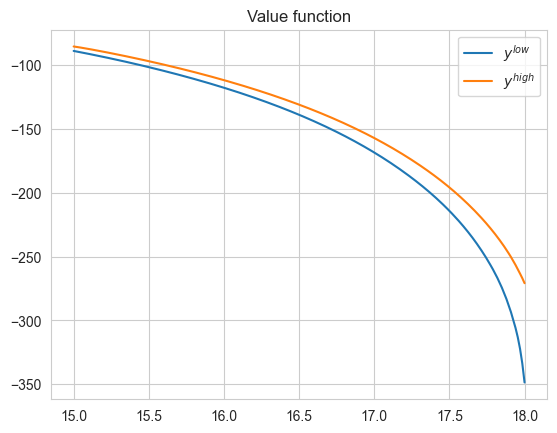

In [69]:
rbc.plot_vf()

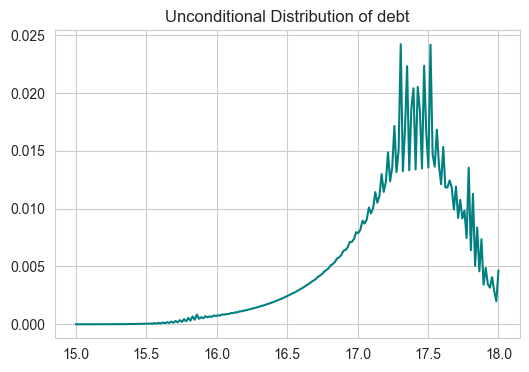

In [70]:
rbc.plot_ud()

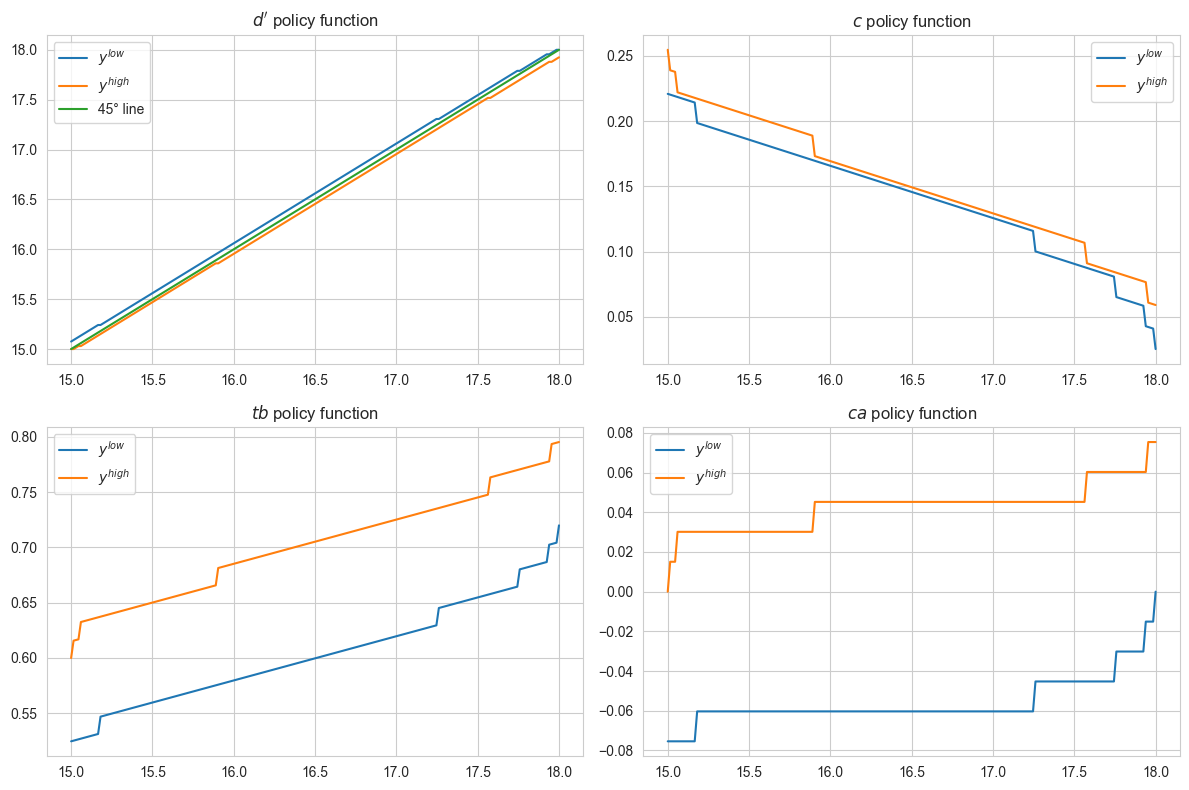

In [71]:
rbc.plot_pf()

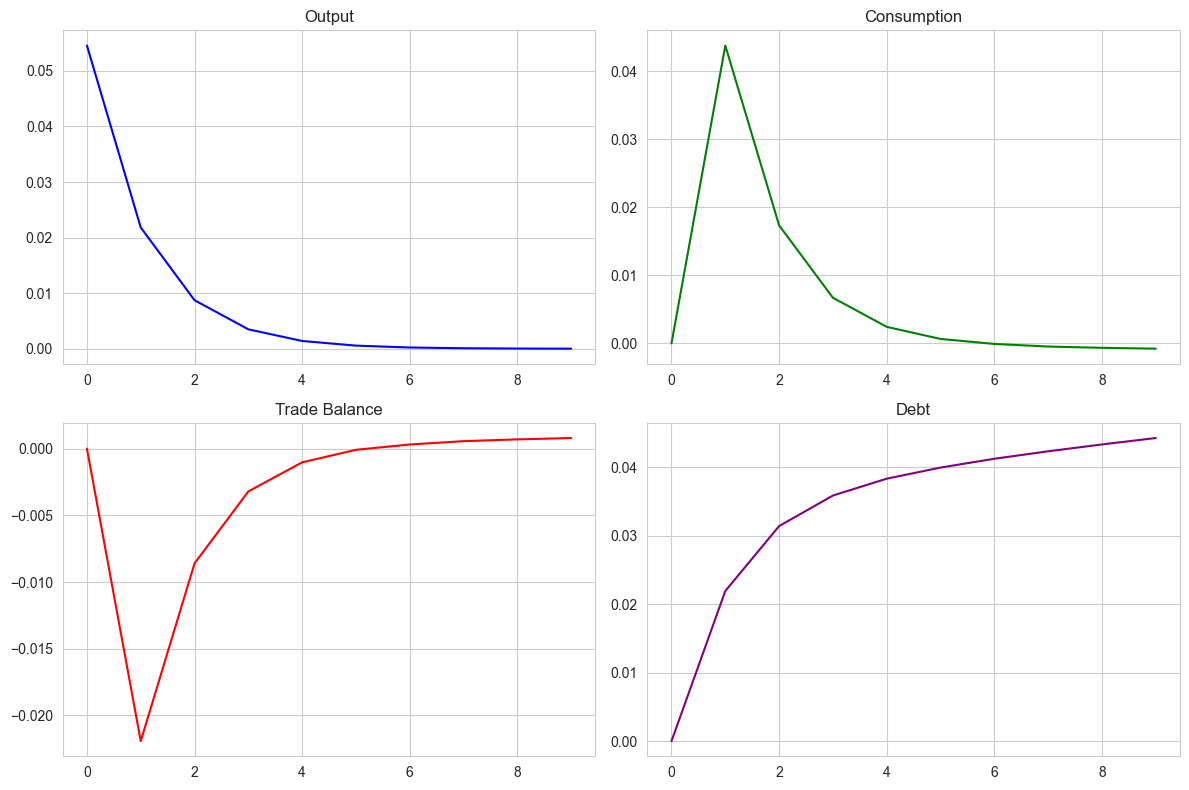

In [72]:
rbc.unconditional_distribution()
IR = rbc.impulse_response(10)
plotmat(IR, ["Output", "Consumption", "Trade Balance", "Debt"], ['blue', 'green', 'red', 'purple'], path+"/IR.png")

In [78]:
rbc2 = dynamic_problem(ρ=0.4,
                      σ=0.05,
                      N=2,
                      s = 2,
                      r = 0.04,
                      β = 0.954,
                      g = 0.22,
                      prec = 200,
                      dmin = 15,
                      dmax = 18)

VFI converged in 449 iterations.


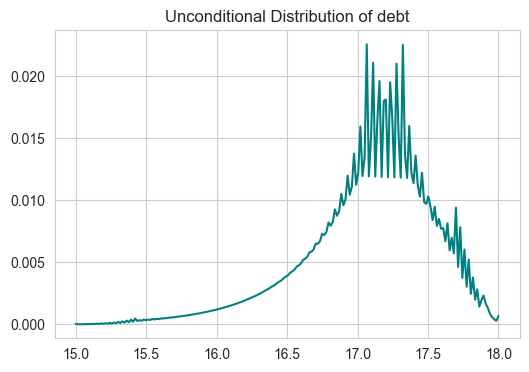

In [79]:
rbc2.vfi()
rbc2.plot_ud()

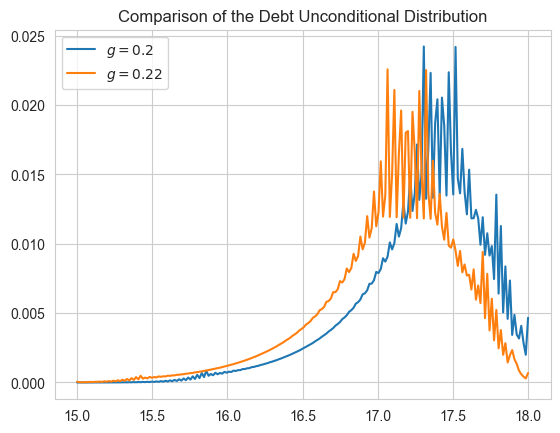

In [80]:
plt.plot(rbc.dgrid, rbc.dist_vec, label="$g=0.2$")
plt.plot(rbc.dgrid, rbc2.dist_vec, label="$g=0.22$")
plt.title("Comparison of the Debt Unconditional Distribution")
plt.legend()
          
plt.savefig(path+"/compare_d_ud.png")
plt.show()